
# Object Detection & Spatial Reasoning with **Qwen 2.5-VL**

This notebook shows how to:
1. load the 7-B-parameter **Qwen 2.5-VL-Instruct** model,  
2. send an image plus a natural-language request in “chat” format for object detection,  
3. receive and decode an the output, and  
4. visualize the detected objects

*Runtime note:* The model uses ~7 GB VRAM in float-16 mode. If you are on a GPU without enough memory, set `device_map="cpu"` instead of `"auto"`.




## 1  Install necessary packages


In [1]:
!pip install qwen-vl-utils  # Upgrade Qwen-VL utilities


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 21.4 MB/s eta 0:00:00


## 2  Imports

In [2]:
# ── Standard library ────────────────────────────────────────────
import os          # File‑system helpers (paths, env vars, etc.)
import random      # Lightweight randomness (e.g. sample prompts)
import textwrap    # Nicely format long strings for display
import io          # In‑memory byte streams (e.g. image buffers)
import requests    # Simple HTTP requests for downloading assets
import re          # Regular expression operations
import json        # Functions for working with JSON data (parse, serialize)
import pprint      # Pretty print JSON

# ── Numerical computing ─────────────────────────────────────────
import numpy as np  # Core array maths (fast, vectorised operations)

# ── Deep‑learning stack ─────────────────────────────────────────
import torch  # Tensor library + GPU acceleration
from transformers import (
    Qwen2_5_VLForConditionalGeneration,  # Multimodal LLM (image+text)
    AutoProcessor,                       # Paired tokenizer/feature‑extractor
)

# ── Imaging & visualisation ─────────────────────────────────────
from PIL import (
    Image,        # Core class for opening, manipulating, and saving images
    ImageDraw,    # Module for drawing on images (shapes, text, etc.)
    ImageFont,    # Module for working with different fonts when drawing text
    ImageColor    # Utility for converting color names/formats to Pillow color values
)
import matplotlib.pyplot as plt          # Quick plots in notebooks
import matplotlib.patches as patches     # Bounding‑box overlays, etc.

# ── Project‑specific helpers ────────────────────────────────────
from qwen_vl_utils import process_vision_info  # Post‑process Qwen outputs

## 3 Output parsing & JSON utilities

The model will ouput results with that is formatted as

```` ```json
    [
	    {"bbox_2d": [x1, y1, x2, y2], "label": "class name"}
   ]
```<|im_end|>````

We will use ```extract_json utility``` to extract just the JSON object.

```[
	    {"bbox_2d": [x1, y1, x2, y2], "label": "class name"}
   ]```

The model sometimes outputs JSON where the string object has an newline. We will fix this using ```_repair_newlines_inside_strings```.

In [3]:
def _repair_newlines_inside_strings(txt: str) -> str:
    """
    Replace raw newlines that occur *inside* JSON string literals with a space.
    Very lightweight: it simply looks for a quote, then any run of characters
    that is NOT a quote or backslash, then a newline, then continues…
    """
    pattern = re.compile(r'("([^"\\]|\\.)*)\n([^"]*")')
    while pattern.search(txt):
        txt = pattern.sub(lambda m: m.group(1) + r'\n' + m.group(3), txt)
    return txt

def extract_json(code_block: str, parse: bool = True):
    """
    Remove Markdown code-block markers (``` or ```json) and return:
      • the raw JSON string   (parse=False, default)
      • the parsed Python obj (parse=True)
    """
    # Look for triple-backtick blocks, optionally tagged with a language (e.g. ```json)
    block_re = re.compile(r"```(?:\w+)?\s*(.*?)\s*```", re.DOTALL)
    m = block_re.search(code_block)
    payload = (m.group(1) if m else code_block).strip()
    if parse:
        try:
            return json.loads(payload)
        except json.JSONDecodeError as e:
            # attempt a mild repair and retry once
            payload_fixed = _repair_newlines_inside_strings(payload)
            return json.loads(payload_fixed)
    else:
        return payload

## 4 Display Utilities

### 4.1 Display image

In [4]:
def display_image(img, title="Image"):
  # Display the image
  plt.figure(figsize=(8, 8))
  plt.imshow(img)
  plt.axis("off")
  plt.title(title)
  plt.show()

### 4.2 Display bounding boxes on image
The ```draw_bbox``` utility draw bounding boxes contained in a JSON array of the form

```
[   {'bbox_2d': [297, 108, 1213, 740], 'label': 'elephant'},
    {'bbox_2d': [20, 421, 536, 723], 'label': 'elephant'}]```

In [5]:
def _text_wh(draw, text, font):
    """
    Return (width, height) of *text* under the given *font*, coping with
    Pillow ≥10.0 (textbbox) and older versions (textsize).
    """
    # Check if the draw object has the 'textbbox' method (Pillow >= 8.0)
    if hasattr(draw, "textbbox"): # Pillow ≥8.0, preferred
        # Get the bounding box of the text
        left, top, right, bottom = draw.textbbox((0, 0), text, font=font)
        # Calculate and return the width and height
        return right - left, bottom - top
    # Check if the draw object has the 'textsize' method (Pillow < 10.0)
    elif hasattr(draw, "textsize"): # Pillow <10.0
        # Get the size of the text
        return draw.textsize(text, font=font)
    # Fallback for other or older versions of Pillow
    else: # Fallback
        # Get the bounding box from the font itself
        left, top, right, bottom = font.getbbox(text)
        # Calculate and return the width and height
        return right - left, bottom - top


def draw_bboxes(
    img,
    detections,
    box_color="red",
    box_width=3,
    font_size=32,
    text_color="white",
    text_bg="red",
):
    # Create a drawing object for the image
    draw = ImageDraw.Draw(img)
    try:
        # Try to load a TrueType font
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except OSError:
        # If TrueType font is not found, load the default font
        font = ImageFont.load_default(font_size)

    # Iterate through each detected object
    for det in detections:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = det["bbox_2d"]
        # Get the label of the detected object, default to empty string if not present
        label = str(det.get("label", ""))

        # Draw the rectangle (bounding box) on the image
        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=box_width)

        # If a label exists, draw the label text
        if label:
            # Get the width and height of the text label
            tw, th = _text_wh(draw, label, font)
            # Set padding around the text
            pad = 2
            # Calculate the top-left x-coordinate for the text background
            tx1 = x1
            # Calculate the top-left y-coordinate for the text background, ensuring it stays within the top edge of the image
            ty1 = max(0, y1 - th - 2 * pad) # keep inside top edge
            # Calculate the bottom-right x-coordinate for the text background
            tx2 = x1 + tw + 2 * pad
            # Calculate the bottom-right y-coordinate for the text background
            ty2 = ty1 + th + 2 * pad

            # If a text background color is specified, draw the background rectangle
            if text_bg:
                draw.rectangle([tx1, ty1, tx2, ty2],
                               fill=text_bg, outline=box_color)
            # Draw the text label on the image
            draw.text((tx1 + pad, ty1 + pad), label,
                      fill=text_color, font=font)

    # Return the modified image with bounding boxes and labels
    return img

## 3  Set device & load model

In [6]:
# Check if a CUDA-enabled GPU is available and set the device accordingly.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the identifier for the specific pre-trained Qwen 2.5-VL model to be loaded.
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

# Load the pre-trained multimodal model from the specified identifier.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    # Automatically select the appropriate data type (FP16 on GPU, FP32 on CPU) for efficiency.
    torch_dtype="auto",
    # Automatically distribute the model's layers across available devices (GPU/CPU).
    device_map="auto"
)

# Load the processor (tokenizer and feature extractor) corresponding to the loaded model.
processor = AutoProcessor.from_pretrained(model_id)

# Print the device on which the model was successfully loaded.
print(f"Model loaded on: {model.device}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Model loaded on: cuda:0


## 4  Load input image
Here we download a sample image from Unsplash, but you can replace the URL or upload your own file.

Interesting quote about elephants by Nassim Taleb


> The elephant, my favorite animal, takes no crap, gives no crap, harms no-one but when one tries to harm it, it has no clemency and never, never forgets.




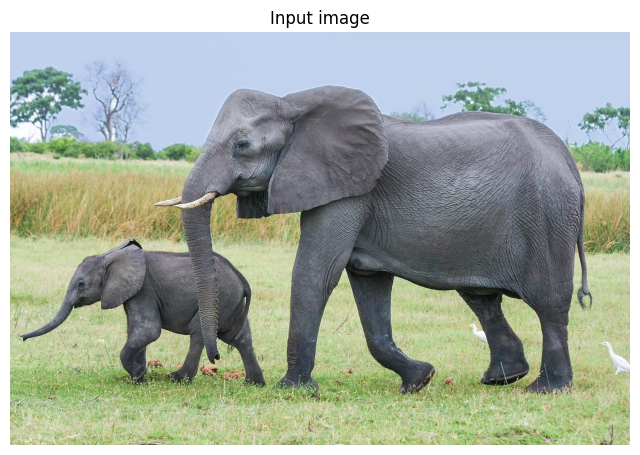

In [10]:
# Define the URL of the image to be downloaded.
url = "https://learnopencv.com/wp-content/uploads/2025/06/elephants.jpg"
#url = "https://images.unsplash.com/photo-1717465760671-c47cb5f8b56f?fm=jpg&q=60&w=3000&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8c2hpcCUyMGluJTIwc2VhfGVufDB8fDB8fHww"

# Download the image from the URL and store the content as bytes.
# A timeout of 15 seconds is set for the request.
img_bytes = requests.get(url, timeout=15).content
# Open the image from the downloaded bytes using Pillow.
# io.BytesIO treats the bytes like a file.
# .convert("RGB") ensures the image is in RGB format (3 color channels).
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
# Display the loaded image using the previously defined display_image function.
# The title "Input image" is provided for the plot.
display_image(img, title="Input image")


## 6  Detect objects and display results

### 6.1 Inference

In [11]:
def inference(model, msgs):
  # Build the full textual prompt that Qwen-VL expects
  text_prompt = processor.apply_chat_template(
    msgs,
    tokenize=False,
    add_generation_prompt=True
  )
  # Extract vision-modalities from msgs and convert them to model-ready tensors
  image_inputs, video_inputs = process_vision_info(msgs)

  # ── Pack text + vision into model-ready tensors ──────────────────────────────
  inputs = processor(
      text=[text_prompt],      # 1-element batch containing the chat prompt string
      images=image_inputs,     # list of raw PIL images (pre-processed inside processor)
      videos=video_inputs,     # list of raw video clips (if any)
      padding=True,            # pad sequences so text/vision tokens line up in a batch
      return_tensors="pt",     # return a dict of PyTorch tensors (input_ids, pixel_values, …)
  ).to(model.device)           # move every tensor—text & vision—to the model’s GPU/CPU

  # ── Run inference (no gradients, pure generation) ───────────────────────────
  with torch.no_grad():                     # disable autograd to save memory
      generated_ids = model.generate(       # autoregressive decoding
          **inputs,                         # unpack dict into generate(...)
          max_new_tokens=1000               # cap the response to max_new_tokens
      )
  # Extract the newly generated tokens (skip the prompt length)
  output = processor.batch_decode(
      generated_ids[:, inputs.input_ids.shape[-1]:],
      skip_special_tokens=False
  )[0]
  print(f"RAW output:\n {output} \n")

  # The above output will be in the following format
  # ```json
  #  [
	#    {"bbox_2d": [x, y, w, h], "label": "class name"}
  # ]
  # ```<|im_end|>
  # We will use extract_json utility to extract just the JSON object.
  # [
	#    {"bbox_2d": [x, y, w, h], "label": "class name"}
  # ]
  bounding_boxes = extract_json(output)
  print("JSON output:\n")
  pprint.pprint(bounding_boxes, indent=4)
  return bounding_boxes


### 6.2 Run inference and draw results

RAW output:
 ```json
[
	{"bbox_2d": [298, 107, 1213, 745], "label": "elephants"},
	{"bbox_2d": [20, 421, 536, 724], "label": "elephants"},
	{"bbox_2d": [1, 71, 156, 228], "label": "trees"},
	{"bbox_2d": [156, 56, 290, 262], "label": "trees"},
	{"bbox_2d": [894, 99, 1032, 170], "label": "trees"},
	{"bbox_2d": [1179, 144, 1288, 253], "label": "trees"}
]
```<|im_end|> 

JSON output:

[   {'bbox_2d': [298, 107, 1213, 745], 'label': 'elephants'},
    {'bbox_2d': [20, 421, 536, 724], 'label': 'elephants'},
    {'bbox_2d': [1, 71, 156, 228], 'label': 'trees'},
    {'bbox_2d': [156, 56, 290, 262], 'label': 'trees'},
    {'bbox_2d': [894, 99, 1032, 170], 'label': 'trees'},
    {'bbox_2d': [1179, 144, 1288, 253], 'label': 'trees'}]


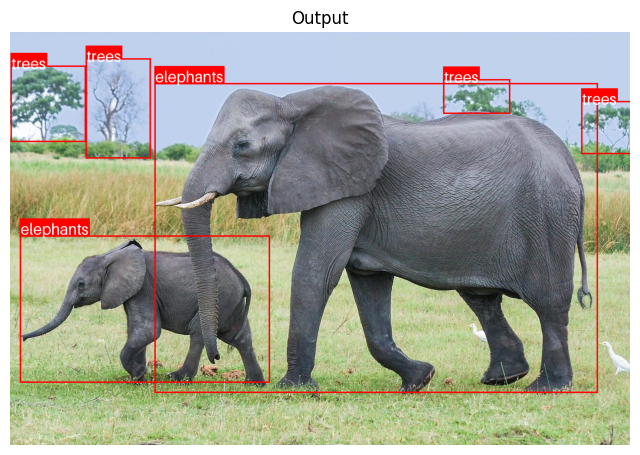

In [18]:
msgs = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an object detector. The format of your output should be a valid JSON object "
                    "{'bbox_2d': [x1, y1, x2, y2], 'label': 'class'} where class is the name of the class you are detecting."
                )
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {
                "type": "text",
                "text": "Outline the position of elephants and the trees one by one"
                #"text": "Outline the position of the ship"

            }
        ],
    }
]

# Run inference
bounding_boxes = inference(model, msgs)

# Draw the bounding boxes on the image
img_out = draw_bboxes(img.copy(), bounding_boxes)

# Display the output
display_image(img_out, title="Output")

RAW output:
 ```json
[
	{"bbox_2d": [20, 423, 532, 726], "label": "small elephants"},
	{"bbox_2d": [950, 593, 993, 638], "label": "birds"},
	{"bbox_2d": [1222, 630, 1288, 701], "label": "birds"},
	{"bbox_2d": [1195, 143, 1288, 252], "label": "trees"},
	{"bbox_2d": [0, 72, 156, 228], "label": "trees"},
	{"bbox_2d": [156, 56, 290, 262], "label": "trees"}
]
```<|im_end|> 

JSON output:

[   {'bbox_2d': [20, 423, 532, 726], 'label': 'small elephants'},
    {'bbox_2d': [950, 593, 993, 638], 'label': 'birds'},
    {'bbox_2d': [1222, 630, 1288, 701], 'label': 'birds'},
    {'bbox_2d': [1195, 143, 1288, 252], 'label': 'trees'},
    {'bbox_2d': [0, 72, 156, 228], 'label': 'trees'},
    {'bbox_2d': [156, 56, 290, 262], 'label': 'trees'}]


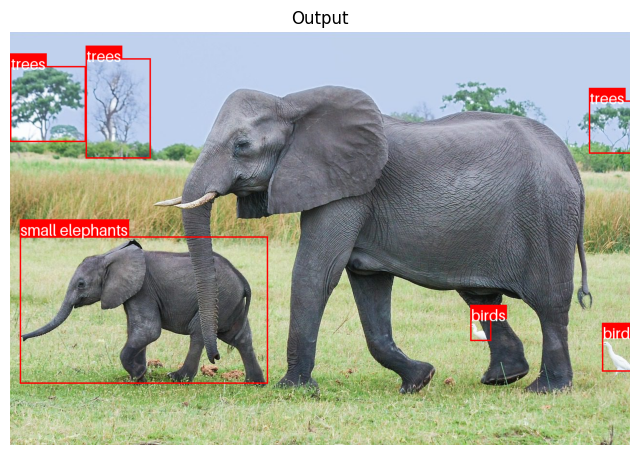

In [22]:
msgs = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an object detector. The format of your output should be a valid JSON object "
                    "{'bbox_2d': [x1, y1, x2, y2], 'label': 'class'} where class is the name of the class you are detecting."
                )
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {
                "type": "text",
                "text": "Outline the position of the small elephants and the birds and trees"
                #"text": "Outline the position of the ship"

            }
        ],
    }
]

# Run inference
bounding_boxes = inference(model, msgs)

# Draw the bounding boxes on the image
img_out = draw_bboxes(img.copy(), bounding_boxes)

# Display the output
display_image(img_out, title="Output")